# Basic Artificial Neural Networks

The goal of this homework is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design of was heavily inspired by [Torch](http://torch.ch) which is the most convenient neural network environment when the work involves defining new layers. 

This homework requires sending **"multiple** files, please do not forget to include all the files when submit. The list of files:
- This notebook
- assignment1_modules.ipynb
- assignment0_differentiation.ipynb

In [1]:
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import matplotlib
from scipy import stats

%matplotlib inline

matplotlib.style.use('ggplot')

# Framework

Implement everything in `Modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return AND store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

In [2]:
"""
--------------------------------------
-- Tech note
--------------------------------------    
np.multiply, np.add, np.divide, np.subtract instead of *,+,/,-
for better memory handling

Suppose you allocated a variable    

    a = np.zeros(...)

So, instead of

    a = b + c  # will be reallocated, GC needed to free

I would go for: 

    np.add(b,c,out = a) # puts result in `a`

But it is completely up to you.
"""

'\n--------------------------------------\n-- Tech note\n--------------------------------------    \nnp.multiply, np.add, np.divide, np.subtract instead of *,+,/,-\nfor better memory handling\n\nSuppose you allocated a variable    \n\n    a = np.zeros(...)\n\nSo, instead of\n\n    a = b + c  # will be reallocated, GC needed to free\n\nI would go for: \n\n    np.add(b,c,out = a) # puts result in `a`\n\nBut it is completely up to you.\n'

In [3]:
# Note that every time you change assignment1_modules.ipynb, 
# You should run this cell to apply your changes
%run assignment1_modules.ipynb

Optimizer is implemented for you. 

In [4]:
def sgd_momentum(x, dx, config, state):
    """
        This is a very ugly implementation of sgd with momentum 
        just to show an example how to store old grad in state.
        Make this function faster if you can!
        
        config:
            - momentum
            - learning_rate
        state:
            - old_grad
    """
    
    # x and dx have complex structure, old dx will be stored in a simpler one
    state.setdefault('old_grad', {})
    
    i = 0 
    for cur_layer_x, cur_layer_dx in zip(x,dx): 
        for cur_x, cur_dx in zip(cur_layer_x,cur_layer_dx):
            
            cur_old_grad = state['old_grad'].setdefault(i, np.zeros_like(cur_dx))
            
            cur_old_grad = config['momentum'] * cur_old_grad + config['learning_rate'] * cur_dx
            
            if cur_old_grad.shape[0] == 1:
                cur_x = cur_x.reshape(cur_old_grad.shape)
            
            np.add(cur_x, -cur_old_grad, out=cur_x)
            i += 1     

Implement [**Adam optimizer**](https://arxiv.org/abs/1412.6980). Test and experiment it. Write your opinion.


In [5]:
def adam_optimizer(x, dx, config):
    # <student.implement_adam>
    
    if config is None: 
        config = {}
    config.setdefault('eps', 1e-8)
    config.setdefault('lr', 1e-3)
    config.setdefault('b1', 0.9)
    config.setdefault('b2', 0.999)
    config.setdefault('moment1', np.zeros_like(x))
    config.setdefault('moment2', np.zeros_like(x))
    config.setdefault('timestep', 0)
    
    next_x = None
    
    config['timestep'] += 1
    config['moment1'] = config['b1'] * config['moment1'] + (1 - config['b1']) * dx
    config['moment2'] = config['b2'] * config['moment2'] + (1 - config['b2'])*(dx ** 2)
    
    moment1t = config['moment1'] / (1 - config['b1'] ** config['timestep'])
    moment2t = config['moment2'] / (1 - config['b2'] ** config['timestep'])
    
    next_x = x - config['lr'] * moment1t / (np.sqrt(moment2t) + config['eps'])

    return next_x, config

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

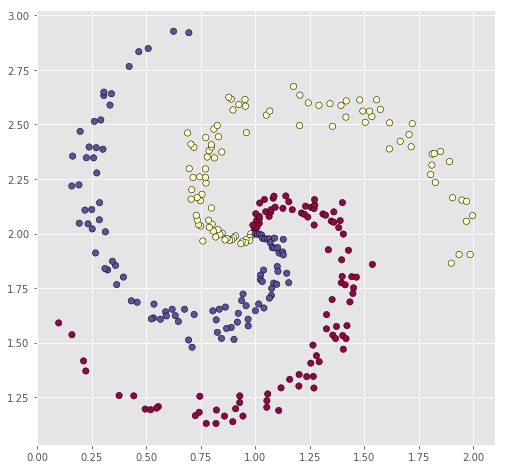

In [6]:
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j
X[:, 0] += 1
X[:, 1] += 2
# lets visualize the data:
plt.figure(figsize=(10,8))
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral, edgecolors="black")
ax = plt.gca()
ax.set_aspect("equal")
plt.show()
import pandas as pd
Y = np.array(pd.get_dummies(y)).astype(int)

Define a **logistic regression** for debugging. 

In [7]:
criterion = MultiLabelCriterion()

# Test something like that then 

net = Sequential()
net.add(Linear(2, 10))
net.add(Sigmoid())
net.add(Linear(10, 3))
net.add(Sigmoid())
# net.add(Linear(10, 3))
# net.add(Sigmoid())

print(net)

Linear 2 -> 10
Sigmoid
Linear 10 -> 3
Sigmoid



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [8]:
# Iptimizer params
optimizer_config = {'learning_rate' : 0.7, 'momentum': 1e-5}
optimizer_state = {}

# Looping params
n_epoch = 1000
batch_size = 1280

In [9]:
# batch generator
def get_batches(X_train, Y_train, batch_size):
    n_samples = X_train.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X_train[batch_idx], Y_train[batch_idx]

### Train

Basic training loop. Examine it.

In [10]:
loss_history = []

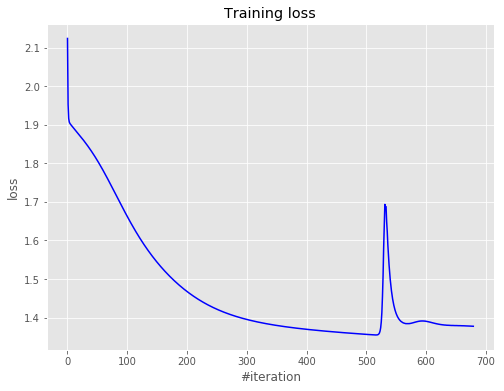

Current loss: 1.377464


In [ ]:
for i in range(n_epoch*10):
    for x_batch, y_batch in get_batches(X, Y, batch_size):
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

In [ ]:
h = 0.02

x_min = X[:, 0].min() - 0.5
x_max =  X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
X0, Y0 = np.meshgrid(np.arange(x_min, x_max, h),
                 np.arange(y_min, y_max, h))

X0flat = X0.reshape(-1)
Y0flat = Y0.flatten()

X1 = np.stack([X0flat, Y0flat]).T

c = np.argmax(net.forward(X1), axis=-1).reshape(X0.shape)

c.shape

plt.figure(figsize=(10,8))
plt.contourf(X0, Y0, c, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=Y.argmax(axis=1), s=40, cmap=plt.cm.Spectral, edgecolors="black")
plt.xlim(X0.min(), X0.max())
plt.ylim(Y0.min(), Y0.max())
plt.gca().set_aspect("equal")
plt.show()

# Digit classification 

In [5]:
N = 100
X = np.concatenate([
    np.random.randn(100, 2)*0.1 + [-1, 1],
    np.random.randn(100, 2)*0.1 + [-1, -1],
    np.random.randn(100, 2)*0.1 + [1, 0]
])
Y = np.zeros((X.shape[0], 3))
Y[0:N, 0] = 1
Y[N:2*N, 1] = 1
Y[2*N:3*N, 2] = 1

In [6]:
criterion = MultiLabelCriterion()

# Test something like that then 

net = Sequential()
net.add(Linear(2, 10))
net.add(Sigmoid())
net.add(Linear(10, 3))
net.add(Sigmoid())
# net.add(Linear(10, 3))
# net.add(Sigmoid())

print(net)

Linear 2 -> 10
Sigmoid
Linear 10 -> 3
Sigmoid



In [7]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-0, 'momentum': 1e-3}
optimizer_state = {}

# Looping params
n_epoch = 40
batch_size = 128

In [8]:
loss_history = []

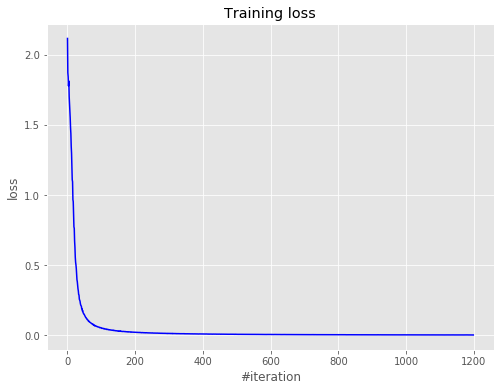

Current loss: 0.002772


In [9]:
for i in range(n_epoch*10):
    for x_batch, y_batch in get_batches(X, Y, batch_size):
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)

We are using [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. Lets start with [cool visualization](http://scs.ryerson.ca/~aharley/vis/). The most beautiful demo is the second one, if you are not familiar with convolutions you can return to it in several lectures. 

In [6]:
N = 100
X = np.concatenate([
    np.random.randn(100, 2)*0.1 + [-1, 1],
    np.random.randn(100, 2)*0.1 + [-1, -1],
    np.random.randn(100, 2)*0.1 + [1, 0]
])
Y = np.zeros((X.shape[0], 3))
Y[0:N, 0] = 1
Y[N:2*N, 1] = 1
Y[2*N:3*N, 2] = 1

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

In [13]:
X_train.shape

(210, 2)

In [14]:
criterion = MultiLabelCriterion()

# Test something like that then 

net = Sequential()
net.add(Linear(2, 10))
net.add(Sigmoid())
net.add(Linear(10, 3))
net.add(SoftMax())
# net.add(Linear(10, 3))
# net.add(Sigmoid())

print(net)

Linear 2 -> 10
Sigmoid
Linear 10 -> 3
SoftMax



In [15]:
loss_train_history = []
loss_validation_history = []
Y_train_prediction = []
Y_test_prediction = []
optimizer_config = {'learning_rate' : 1e-0, 'momentum': 1e-3}
optimizer_state = {}

n_epoch=4
batch_size=10

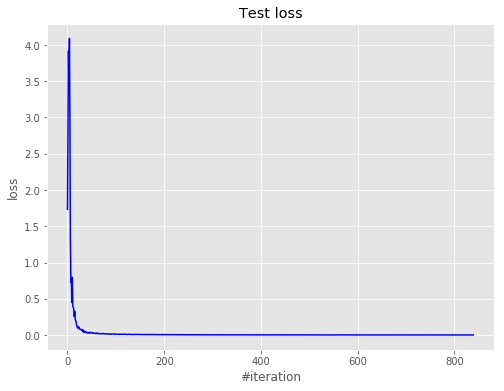

Current loss: 0.001144


In [16]:
for i in range(n_epoch*10):
        
    for x_batch, y_batch in get_batches(X_train, Y_train, batch_size):
        net.zeroGradParameters()

        # Forward
        predictions = net.forward(x_batch)
        loss_train = criterion.forward(predictions, y_batch)
        loss_train_history.append(loss_train)

        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)

        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config, 
                     optimizer_state)      
        
        test_idx = np.random.randint(0, X_test.shape[0], batch_size)
        loss_test = criterion.forward(net.forward(X_test[test_idx]),Y_test[test_idx])
        loss_validation_history.append(loss_test)



    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Test loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_validation_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss_test)